Import All Libraries Required

In [21]:
from typing import NamedTuple, Optional, Tuple, Generator, List, Dict
from matplotlib import pyplot as plt
from skimage.draw import circle_perimeter_aa

import random
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import _LRScheduler
from tqdm import tqdm

Set the Seed to be 42 for Reproducibility

In [2]:
def set_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

set_seeds(42)

Helper Functions Provided to Generate Example Images

In [3]:
class CircleParams(NamedTuple):
    row: int
    col: int
    radius: int


def draw_circle(img: np.ndarray, row: int, col: int, radius: int) -> np.ndarray:
    """
    Draw a circle in a numpy array, inplace.
    The center of the circle is at (row, col) and the radius is given by radius.
    The array is assumed to be square.
    Any pixels outside the array are ignored.
    Circle is white (1) on black (0) background, and is anti-aliased.
    """
    rr, cc, val = circle_perimeter_aa(row, col, radius)
    valid = (rr >= 0) & (rr < img.shape[0]) & (cc >= 0) & (cc < img.shape[1])
    img[rr[valid], cc[valid]] = val[valid]
    return img


def noisy_circle(
    img_size: int, min_radius: float, max_radius: float, noise_level: float
) -> Tuple[np.ndarray, CircleParams]:
    """
    Draw a circle in a numpy array, with normal noise.
    """

    # Create an empty image
    img = np.zeros((img_size, img_size))

    radius = np.random.randint(min_radius, max_radius)

    # x,y coordinates of the center of the circle
    row, col = np.random.randint(img_size, size=2)

    # Draw the circle inplace
    draw_circle(img, row, col, radius)

    added_noise = np.random.normal(0.5, noise_level, img.shape)
    img += added_noise

    return img, CircleParams(row, col, radius)


def show_circle(img: np.ndarray):
    fig, ax = plt.subplots()
    ax.imshow(img, cmap="gray")
    ax.set_title("Circle")
    plt.show()


def generate_examples(
    noise_level: float = 0.5,
    img_size: int = 100,
    min_radius: Optional[int] = None,
    max_radius: Optional[int] = None,
    dataset_path: str = "ds",
) -> Generator[Tuple[np.ndarray, CircleParams], None, None]:
    if not min_radius:
        min_radius = img_size // 10
    if not max_radius:
        max_radius = img_size // 2
    assert max_radius > min_radius, "max_radius must be greater than min_radius"
    assert img_size > max_radius, "size should be greater than max_radius"
    assert noise_level >= 0, "noise should be non-negative"

    params = (
        f"{noise_level=}, {img_size=}, {min_radius=}, {max_radius=}, {dataset_path=}"
    )
    print(f"Using parameters: {params}")
    while True:
        img, params = noisy_circle(
            img_size=img_size,
            min_radius=min_radius,
            max_radius=max_radius,
            noise_level=noise_level,
        )
        yield img, params


def iou(a: CircleParams, b: CircleParams) -> float:
    """Calculate the intersection over union of two circles"""
    r1, r2 = a.radius, b.radius
    d = np.linalg.norm(np.array([a.row, a.col]) - np.array([b.row, b.col]))
    if d > r1 + r2:
        # If the distance between the centers is greater than the sum of the radii, then the circles don't intersect
        return 0.0
    if d <= abs(r1 - r2):
        # If the distance between the centers is less than the absolute difference of the radii, then one circle is
        # inside the other
        larger_r, smaller_r = max(r1, r2), min(r1, r2)
        return smaller_r**2 / larger_r**2
    r1_sq, r2_sq = r1**2, r2**2
    d1 = (r1_sq - r2_sq + d**2) / (2 * d)
    d2 = d - d1
    sector_area1 = r1_sq * np.arccos(d1 / r1)
    triangle_area1 = d1 * np.sqrt(r1_sq - d1**2)
    sector_area2 = r2_sq * np.arccos(d2 / r2)
    triangle_area2 = d2 * np.sqrt(r2_sq - d2**2)
    intersection = sector_area1 + sector_area2 - (triangle_area1 + triangle_area2)
    union = np.pi * (r1_sq + r2_sq) - intersection
    return intersection / union

In [4]:
def calculate_iou(a: torch.Tensor, b: torch.Tensor) -> float:
    """
    Calculate the Intersection Over Union (IOU) of two circles represented as torch tensors.

    Each circle is represented by a tensor containing (x, y, radius).

    Args:
        a (torch.Tensor): The first circle represented as a tensor.
        b (torch.Tensor): The second circle represented as a tensor.

    Returns:
        float: The IOU of the two circles.
    """
    # Convert PyTorch tensors to numpy arrays for IOU calculation
    a_np = a.cpu().detach().numpy()
    b_np = b.cpu().detach().numpy()

    # Convert to CircleParams format for the IOU function
    a_circle_params = CircleParams(*a_np)
    b_circle_params = CircleParams(*b_np)

    # Calculate and return the IOU
    return iou(a_circle_params, b_circle_params)

### Step 1: Dataset Generation
*   Use the provided generate_examples function to create a dataset of images with noisy circles.
*   Split the dataset into training, validation, and test sets.

In [5]:
# Parameters for dataset generation
n_train = 50000
n_val = 5000
n_test = 5000
img_size = 100

# Generate the dataset
example_generator = generate_examples(noise_level=0.5, img_size=img_size)
train_images = np.zeros((n_train, img_size, img_size))
train_labels = np.zeros((n_train, 3))

for i in range(n_train):
    train_images[i], train_labels[i] = next(example_generator)
val_images = np.zeros((n_val, img_size, img_size))
val_labels = np.zeros((n_val, 3))
for i in range(n_val):
    val_images[i], val_labels[i] = next(example_generator)
test_images = np.zeros((n_test, img_size, img_size))
test_labels = np.zeros((n_test, 3))
for i in range(n_test):
    test_images[i], test_labels[i] = next(example_generator)

Using parameters: noise_level=0.5, img_size=100, min_radius=10, max_radius=50, dataset_path='ds'


Plot some of the generated circles and their corresponding labels for a sanity check and to get a sense of how they look like

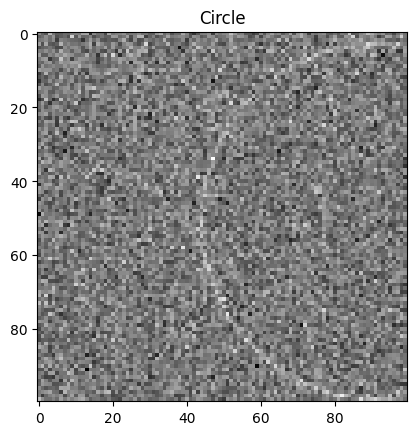

In [6]:
show_circle(train_images[0])

In [7]:
train_labels[0]

array([51., 92., 48.])

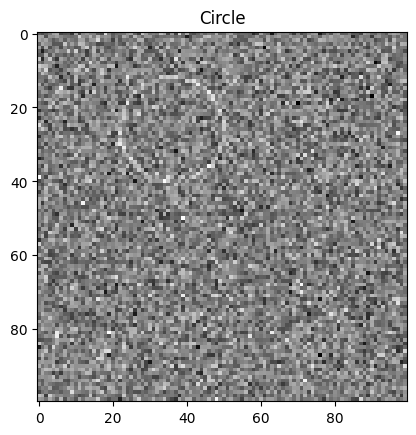

In [8]:
show_circle(val_images[0])

In [9]:
val_labels[0]

array([26., 36., 14.])

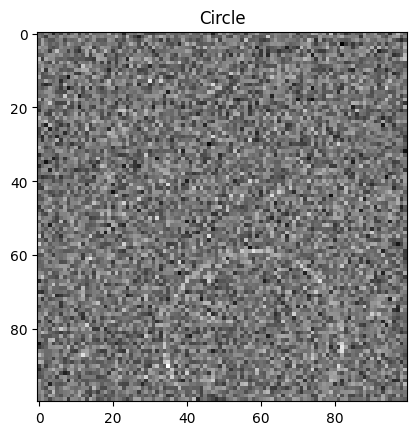

In [10]:
show_circle(test_images[0])

In [11]:
test_labels[0]

array([83., 58., 24.])

### Step 2: Defining the PyTorch CircleDataset Class

In [12]:
class CircleDataset(Dataset):
    """
    A custom dataset for handling images and labels of circles.

    Attributes:
        images (torch.Tensor): A tensor containing the images.
        labels (torch.Tensor): A tensor containing the labels for the images.
    """

    def __init__(self, images: np.ndarray, labels: np.ndarray):
        """
        Initializes the CircleDataset.

        Args:
            images (np.ndarray): The array of images.
            labels (np.ndarray): The corresponding array of labels.
        """
        # Convert images to torch.Tensor
        self.images = torch.from_numpy(images).float()
        # Convert labels to torch.Tensor
        self.labels = torch.from_numpy(labels).float()

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Retrieves an image-label pair from the dataset at the specified index.

        Args:
            index (int): The index of the item to retrieve.

        Returns:
            tuple: A tuple containing the image and its corresponding label.
        """
        # Retrieve the image and its label based on the index
        image = self.images[index]
        label = self.labels[index]

        # Add a channel dimension to the image
        image = torch.unsqueeze(image, 0)

        # Return the image and its label as a tuple
        return (image, label)

    def __len__(self) -> int:
        """
        Returns the total number of items in the dataset.

        Returns:
            int: The size of the dataset.
        """
        # Return the number of labels, which is the size of the dataset
        return self.labels.size(0)

In [13]:
train_dataset = CircleDataset(train_images, train_labels)
val_dataset = CircleDataset(val_images, val_labels)
test_dataset = CircleDataset(test_images, test_labels)

# Create Data Loaders
# Set a batch_size of 1024 (just enough to fit in 15GB of Colab Memory)
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1024, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

### Step 3: Defining the Model Architecture & Training Loop

In [14]:
class CircleDetectorCNN(nn.Module):
    """
    A convolutional neural network designed for detecting circles in images.

    Attributes:
        conv_layers (nn.Sequential): Sequential container of convolutional layers.
        fc_layers (nn.Sequential): Sequential container of fully connected layers.
    """

    def __init__(self):
        """
        Initializes the CircleDetectorCNN model. This includes setting up the convolutional
        layers and fully connected layers of the network.
        """
        super(CircleDetectorCNN, self).__init__()

        # Convolutional layers
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, 5, padding=1),  # Convolutional layer with 32 filters
            nn.BatchNorm2d(32),  # Batch normalization
            nn.ReLU(),  # ReLU activation
            nn.MaxPool2d(2, 2),  # Max pooling
            # Additional convolutional layers with increasing filter sizes
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(256, 512, 3, padding=3),
            nn.BatchNorm2d(512),
            nn.ReLU(),
        )

        # Fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Linear(512 * 5 * 5, 256),  # First fully connected layer
            nn.ReLU(),  # ReLU activation
            nn.Linear(256, 128),  # Second fully connected layer
            nn.ReLU(),
            nn.Linear(128, 3),  # Output layer with 3 units for (row, col, radius)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Defines the forward pass of the model.

        Args:
            x (torch.Tensor): The input tensor containing the image data.

        Returns:
            torch.Tensor: The output tensor after passing through the network.
        """
        x = self.conv_layers(x)  # Pass the input through the convolutional layers
        x = x.view(-1, 512 * 5 * 5)  # Flatten the output for the fully connected layers
        x = self.fc_layers(x)  # Pass flattened output through fully connected layers
        return x

In [18]:
def train_model(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    criterion: nn.modules.loss._Loss,
    optimizer: optim.Optimizer,
    scheduler: _LRScheduler,
    num_epochs: int = 20,
    patience: int = 5,
) -> Tuple[List[float], List[float]]:
    """
    Trains a PyTorch model and performs validation.

    Args:
        model (nn.Module): The neural network model to train.
        train_loader (DataLoader): DataLoader for the training dataset.
        val_loader (DataLoader): DataLoader for the validation dataset.
        criterion (nn.modules.loss._Loss): The loss function.
        optimizer (optim.Optimizer): The optimization algorithm.
        scheduler (_LRScheduler): Learning rate scheduler.
        num_epochs (int): Total number of training epochs.
        patience (int): Patience for early stopping.

    Returns:
        Tuple[List[float], List[float]]: A tuple containing the training and validation losses.
    """
    # Set the device to GPU if available, otherwise use CPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    best_val_loss = float("inf")
    epochs_no_improve = 0

    train_losses: List[float] = []
    val_losses: List[float] = []

    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0

        for inputs, labels in tqdm(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        scheduler.step()

        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)
        print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {epoch_loss:.4f}")

        val_loss = validate_model(model, val_loader, criterion, device)
        val_losses.append(val_loss)

        # Check for improvement in validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                print(f"Early stopping triggered after {epoch + 1} epochs")
                break  # Early stopping
            print(f"Validation Loss has not decreased for {epochs_no_improve} epochs")
    return train_losses, val_losses


def validate_model(
    model: nn.Module,
    val_loader: DataLoader,
    criterion: nn.modules.loss._Loss,
    device: torch.device,
) -> float:
    """
    Validates the model using a validation set.

    Args:
        model (nn.Module): The model to validate.
        val_loader (DataLoader): DataLoader for the validation dataset.
        criterion (nn.modules.loss._Loss): The loss function.
        device (torch.device): The device to run the model on.

    Returns:
        float: The average validation loss.
    """
    model.eval()  # Set model to evaluation mode
    running_loss = 0.0

    with torch.no_grad():  # Disable gradient computation
        for inputs, labels in tqdm(val_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
    epoch_loss = running_loss / len(val_loader)
    print(f"Validation Loss: {epoch_loss:.4f}")
    return epoch_loss

In [19]:
# Initialize the CircleDetectorCNN model
model = CircleDetectorCNN()

# Define the loss function using L1 Loss
criterion = nn.L1Loss()

# Set up the optimizer using Adam with a learning rate of 0.001
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define a learning rate scheduler that decays the learning rate
# by a factor of 0.05 every 5 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.05)

In [20]:
# Define the number of epochs and the patience for early stopping
num_epochs = 20
patience = 5

# Train the model and store the training and validation losses
train_losses, val_losses = train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    num_epochs,
    patience,
)

100%|██████████| 49/49 [00:30<00:00,  1.59it/s]


Epoch 1/20, Training Loss: 17.7530


100%|██████████| 5/5 [00:01<00:00,  4.39it/s]


Validation Loss: 14.9998


100%|██████████| 49/49 [00:30<00:00,  1.61it/s]


Epoch 2/20, Training Loss: 5.9593


100%|██████████| 5/5 [00:01<00:00,  4.39it/s]


Validation Loss: 4.4931


100%|██████████| 49/49 [00:30<00:00,  1.61it/s]


Epoch 3/20, Training Loss: 2.9963


100%|██████████| 5/5 [00:01<00:00,  4.32it/s]


Validation Loss: 3.2354


100%|██████████| 49/49 [00:30<00:00,  1.62it/s]


Epoch 4/20, Training Loss: 2.4631


100%|██████████| 5/5 [00:01<00:00,  4.39it/s]


Validation Loss: 2.8806


100%|██████████| 49/49 [00:30<00:00,  1.62it/s]


Epoch 5/20, Training Loss: 2.2252


100%|██████████| 5/5 [00:01<00:00,  4.42it/s]


Validation Loss: 2.8514


100%|██████████| 49/49 [00:30<00:00,  1.63it/s]


Epoch 6/20, Training Loss: 1.5500


100%|██████████| 5/5 [00:01<00:00,  4.45it/s]


Validation Loss: 1.3683


100%|██████████| 49/49 [00:30<00:00,  1.61it/s]


Epoch 7/20, Training Loss: 1.2161


100%|██████████| 5/5 [00:01<00:00,  4.23it/s]


Validation Loss: 1.2587


100%|██████████| 49/49 [00:30<00:00,  1.62it/s]


Epoch 8/20, Training Loss: 1.1893


100%|██████████| 5/5 [00:01<00:00,  4.42it/s]


Validation Loss: 1.2384


100%|██████████| 49/49 [00:30<00:00,  1.62it/s]


Epoch 9/20, Training Loss: 1.2175


100%|██████████| 5/5 [00:01<00:00,  4.41it/s]


Validation Loss: 1.3644
Validation Loss has not decreased for 1 epochs


100%|██████████| 49/49 [00:30<00:00,  1.63it/s]


Epoch 10/20, Training Loss: 1.1920


100%|██████████| 5/5 [00:01<00:00,  4.19it/s]


Validation Loss: 1.2765
Validation Loss has not decreased for 2 epochs


100%|██████████| 49/49 [00:30<00:00,  1.62it/s]


Epoch 11/20, Training Loss: 1.1451


100%|██████████| 5/5 [00:01<00:00,  4.41it/s]


Validation Loss: 1.1672


100%|██████████| 49/49 [00:30<00:00,  1.62it/s]


Epoch 12/20, Training Loss: 1.1203


100%|██████████| 5/5 [00:01<00:00,  4.40it/s]


Validation Loss: 1.1657


100%|██████████| 49/49 [00:30<00:00,  1.62it/s]


Epoch 13/20, Training Loss: 1.0849


100%|██████████| 5/5 [00:01<00:00,  4.17it/s]


Validation Loss: 1.1650


100%|██████████| 49/49 [00:30<00:00,  1.62it/s]


Epoch 14/20, Training Loss: 1.0869


100%|██████████| 5/5 [00:01<00:00,  4.44it/s]


Validation Loss: 1.1613


100%|██████████| 49/49 [00:30<00:00,  1.63it/s]


Epoch 15/20, Training Loss: 1.1182


100%|██████████| 5/5 [00:01<00:00,  4.42it/s]


Validation Loss: 1.1592


100%|██████████| 49/49 [00:30<00:00,  1.62it/s]


Epoch 16/20, Training Loss: 1.1079


100%|██████████| 5/5 [00:01<00:00,  4.32it/s]


Validation Loss: 1.1605
Validation Loss has not decreased for 1 epochs


100%|██████████| 49/49 [00:30<00:00,  1.62it/s]


Epoch 17/20, Training Loss: 1.0662


100%|██████████| 5/5 [00:01<00:00,  4.36it/s]


Validation Loss: 1.1617
Validation Loss has not decreased for 2 epochs


100%|██████████| 49/49 [00:30<00:00,  1.62it/s]


Epoch 18/20, Training Loss: 1.1105


100%|██████████| 5/5 [00:01<00:00,  4.39it/s]


Validation Loss: 1.1746
Validation Loss has not decreased for 3 epochs


100%|██████████| 49/49 [00:30<00:00,  1.62it/s]


Epoch 19/20, Training Loss: 1.1028


100%|██████████| 5/5 [00:01<00:00,  4.40it/s]


Validation Loss: 1.1597
Validation Loss has not decreased for 4 epochs


100%|██████████| 49/49 [00:30<00:00,  1.62it/s]


Epoch 20/20, Training Loss: 1.0878


100%|██████████| 5/5 [00:01<00:00,  4.19it/s]

Validation Loss: 1.1632
Early stopping triggered after 20 epochs


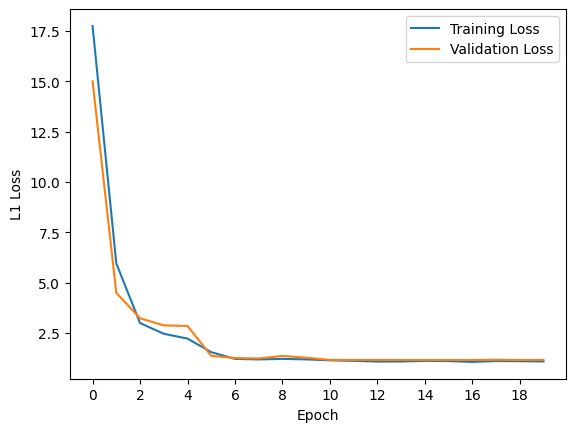

In [22]:
# Plotting the training and validation losses
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("L1 Loss")
plt.xticks(np.arange(0, num_epochs, 2))  # Set the x-ticks to show every 2 epochs
plt.legend()
plt.savefig("loss.png")

In [23]:
# Save the model for download
torch.save(model.state_dict(), "model_noise0.5.pt")

### Step 4: IOU Calculation on Unseen Test Set

In [24]:
def evaluate_model(
    model: torch.nn.Module,
    test_loader: DataLoader,
    thresholds: List[float] = [0.5, 0.75, 0.9, 0.95],
) -> Dict[float, float]:
    """
    Evaluate the model on the test dataset and calculate the IOU for different thresholds.

    Args:
        model (torch.nn.Module): The trained model for evaluation.
        test_loader (DataLoader): DataLoader for the test dataset.
        thresholds (List[float]): List of IOU thresholds for evaluation.

    Returns:
        Dict[float, float]: A dictionary mapping each threshold to its corresponding IOU percentage.
    """
    # Set the device to GPU if available, otherwise use CPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()  # Set the model to evaluation mode
    # Initialize IOU count for each threshold
    iou_counts = {threshold: 0 for threshold in thresholds}
    num_samples = 0  # Number of samples processed
    total_iou = 0.0  # Total IOU for all samples

    with torch.no_grad():  # Disable gradient calculation
        for inputs, labels in tqdm(test_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)  # Get model predictions

            for i in range(inputs.size(0)):
                current_iou = calculate_iou(
                    outputs[i], labels[i]
                )  # Calculate IOU for each example
                total_iou += current_iou
                num_samples += 1

                for (
                    threshold
                ) in thresholds:  # Count examples meeting each IOU threshold
                    if current_iou >= threshold:
                        iou_counts[threshold] += 1
    average_iou = total_iou / num_samples  # Calculate average IOU
    print(f"\nAverage IOU on Test Set: {average_iou:.4f}")

    # Calculate percentage of examples meeting or exceeding each IOU threshold
    iou_percentages = {
        threshold: (count / num_samples) for threshold, count in iou_counts.items()
    }
    return iou_percentages

In [25]:
# Calculate the Average IOU on test set as well as the percentage of samples meeting or exceeding each IOU threshold
iou_thresholds = [0.5, 0.75, 0.9, 0.95]
iou_percentages = evaluate_model(model, test_loader, iou_thresholds)

for threshold, percentage in iou_percentages.items():
    print(f"\nFraction of test examples with IOU >= {threshold}: {percentage:.4f}")

100%|██████████| 5/5 [00:01<00:00,  3.17it/s]


Average IOU on Test Set: 0.8850

Fraction of test examples with IOU >= 0.5: 0.9840

Fraction of test examples with IOU >= 0.75: 0.9108

Fraction of test examples with IOU >= 0.9: 0.6160

Fraction of test examples with IOU >= 0.95: 0.2500


### Step 5: Visualize some of the Model Predictions against the ground truth

In [26]:
def get_preds(model: torch.nn.Module, pred_loader: DataLoader) -> None:
    """
    Generates and visualizes predictions from the model on a set of examples.

    Args:
        model (torch.nn.Module): The trained model for prediction.
        pred_loader (DataLoader): DataLoader containing the data for prediction.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()  # Set the model to evaluation mode

    with torch.no_grad():
        for input, label in tqdm(pred_loader):
            input, label = input.to(device), label.to(device)

            output = model(input)  # Generate model prediction
            print("predicted output is", output[0])
            print("ground truth is", label[0])

            iou = calculate_iou(output[0], label[0])  # Calculate IOU

            # Convert output to numpy array and prepare the image for visualization
            row, col, radius = output[0].cpu().detach().numpy()
            img = np.squeeze(input.cpu().detach().numpy())

            # Draw the predicted circle
            draw_circle(img, int(row), int(col), int(radius))
            show_circle(img)  # Display the image

            print(f"\nIOU = {iou:.4f}")

In [27]:
# Number of predictions to visualize
n_pred = 10
img_size = 100

# Generate prediction images and labels
pred_images = np.zeros((n_pred, img_size, img_size))
pred_labels = np.zeros((n_pred, 3))

for i in range(n_pred):
    pred_images[i], pred_labels[i] = next(example_generator)
# Create dataset and dataloader for the predictions
pred_dataset = CircleDataset(pred_images, pred_labels)
pred_loader = DataLoader(pred_dataset, batch_size=1, shuffle=False)

  0%|          | 0/10 [00:00<?, ?it/s]

predicted output is tensor([37.5515, 37.8680, 49.3182], device='cuda:0')
ground truth is tensor([36., 39., 48.], device='cuda:0')


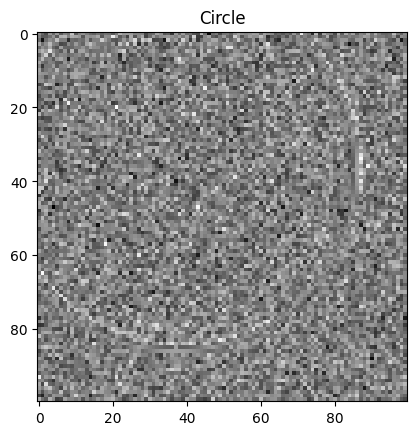

 10%|█         | 1/10 [00:00<00:02,  3.85it/s]


IOU = 0.9393
predicted output is tensor([ 7.6269, 85.8560, 40.7920], device='cuda:0')
ground truth is tensor([ 4., 88., 43.], device='cuda:0')


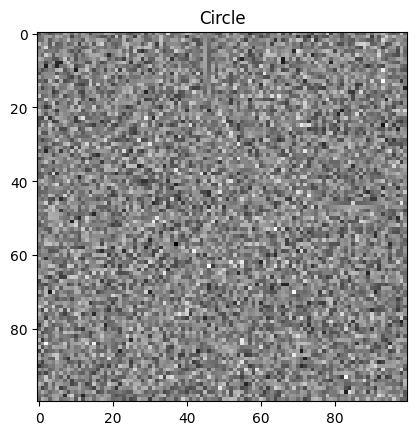

 20%|██        | 2/10 [00:00<00:01,  4.65it/s]


IOU = 0.8640
predicted output is tensor([55.2922, 51.2924, 11.5619], device='cuda:0')
ground truth is tensor([56., 50., 11.], device='cuda:0')


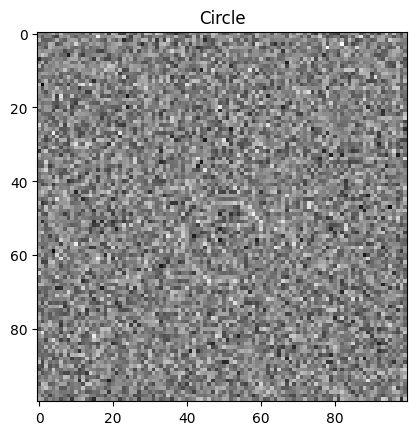

 30%|███       | 3/10 [00:00<00:01,  4.84it/s]


IOU = 0.8363
predicted output is tensor([29.0286, 68.3639, 37.1948], device='cuda:0')
ground truth is tensor([29., 68., 37.], device='cuda:0')


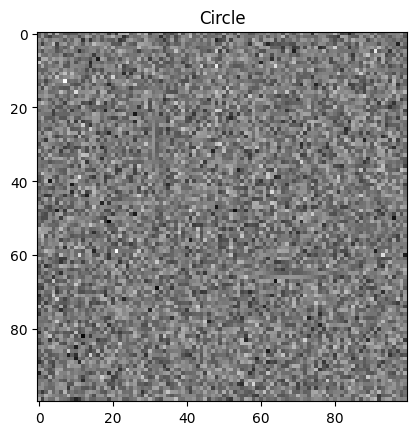

 40%|████      | 4/10 [00:00<00:01,  4.98it/s]


IOU = 0.9857
predicted output is tensor([44.8431, 48.7661, 40.7158], device='cuda:0')
ground truth is tensor([46., 51., 42.], device='cuda:0')


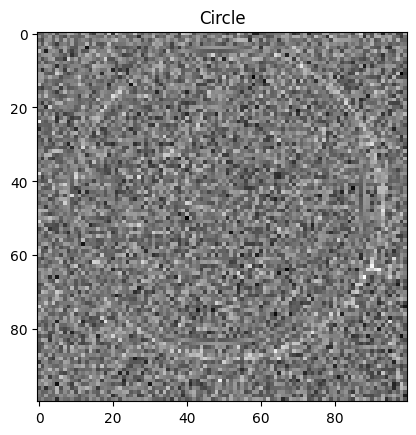

 50%|█████     | 5/10 [00:01<00:01,  5.00it/s]


IOU = 0.9159
predicted output is tensor([67.1460, 93.5048, 28.1411], device='cuda:0')
ground truth is tensor([66., 92., 28.], device='cuda:0')


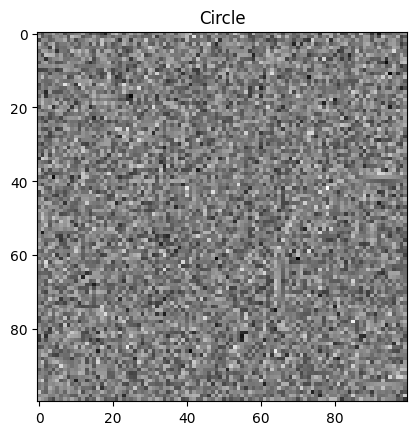


IOU = 0.9175


 60%|██████    | 6/10 [00:01<00:00,  5.01it/s]

predicted output is tensor([79.5959, 16.9336, 31.2517], device='cuda:0')
ground truth is tensor([79., 17., 32.], device='cuda:0')


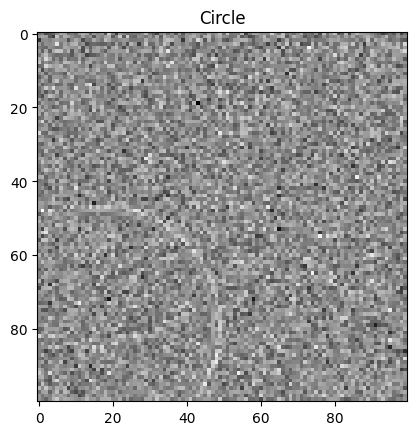

 70%|███████   | 7/10 [00:01<00:00,  5.10it/s]


IOU = 0.9538
predicted output is tensor([85.1277, 92.7318, 33.7762], device='cuda:0')
ground truth is tensor([84., 92., 32.], device='cuda:0')


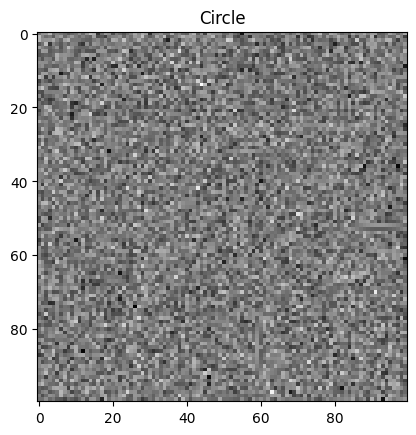

 80%|████████  | 8/10 [00:01<00:00,  5.06it/s]


IOU = 0.8976
predicted output is tensor([64.6387, 66.4629, 30.5981], device='cuda:0')
ground truth is tensor([64., 67., 32.], device='cuda:0')


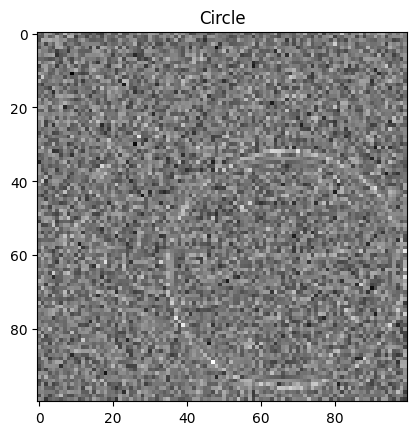

 90%|█████████ | 9/10 [00:01<00:00,  5.14it/s]


IOU = 0.9143
predicted output is tensor([64.3929, 52.0783,  8.9198], device='cuda:0')
ground truth is tensor([65., 54., 10.], device='cuda:0')


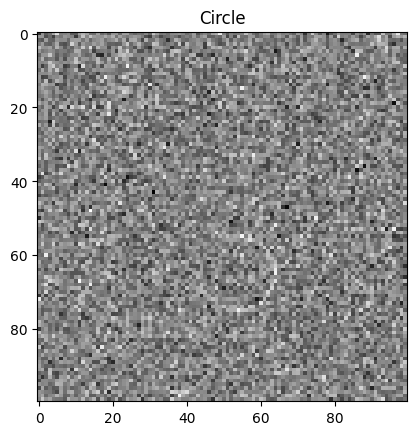

100%|██████████| 10/10 [00:02<00:00,  4.99it/s]


IOU = 0.7317


In [28]:
# Visualize model predictions
get_preds(model, pred_loader)